In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/songlist.xlsx')

# Selecting 4 characteristics
characteristics = ['danceability' , 'energy' , 'loudness' , 'tempo']
X = df[characteristics].values

# Standardizing the data
mean_X = np.mean(X,axis=0)
std_X = np.std(X,axis=0)
standardized_X = (X-mean_X)/std_X

print(standardized_X.shape)

(3090, 4)


# a)

In [ ]:
def gaussian_pdf(x, mu, sigma):
  n = len(x)
  sigma = sigma + np.eye(sigma.shape[0]) * 1e-6 # adding small values on the diagonal to avoid singular matrix
  return (2*np.pi) **(-n/2) * (np.linalg.det(sigma) **(-0.5)) * np.exp(-0.5 * (x-mu).T @ np.linalg.inv(sigma) @ (x-mu))

In [ ]:
def component_pdfs(x, mus, sigmas):
  n_components = mus.shape[0]
  return np.array([gaussian_pdf(x, mus[k,:], sigmas[k, :, :]) for k in range(n_components)])

In [ ]:
def likelihood_function(X, w, mus, sigmas):
  N = X.shape[0]
  get_component_prob = lambda x: component_pdfs(x, mus, sigmas)
  T = np.apply_along_axis(get_component_prob, 1, X)
  return np.sum(np.log(np.dot (T, w)))

In [ ]:
def e_step(X, w, mus, sigmas):
  N = X.shape[0]
  K = mus.shape[0]
  pdf_matrix = np.array([component_pdfs(x, mus, sigmas) for x in X]) # shape (N, K)
  weighted_pdf = pdf_matrix * w
  denom = np.sum(weighted_pdf, axis=1, keepdims = True)
  T = weighted_pdf / denom
  return T

In [ ]:
def m_step(X, T):
  N, n = X.shape
  K = T.shape[1]
  w = np.sum(T, axis=0) / N # mixture weight
  mus = np.zeros((K, n))  # means
  sigmas = np.zeros((K, n, n)) # sigmas
  for k in range(K):
    weight_k = T[:,k].reshape(-1,1)
    sum_weight = np.sum(weight_k)
    mus[k,:] = np.sum(weight_k * X, axis = 0) / sum_weight
    X_centered = X - mus[k,:]
    sigmas[k,:,:] = (weight_k * X_centered).T @ X_centered / sum_weight
  return w, mus, sigmas

In [ ]:
class GaussianMixture():
  def __init__(self, n_hidden = 5, max_iter=100,seed = 42,tol=1e-4):
    self.n_hidden = n_hidden
    self.max_iter = max_iter
    self.seed = seed
    self.tol = tol
    self.w, self.mus, self.sigmas = None, None, None

  def fit(self, X):
    np.random.seed(self.seed)
    N, n = X.shape
    K = self.n_hidden

    idx = np.random.choice(N, size = K, replace = False)
    mus = X[idx,:].copy()
    sigmas = np.array([np.eye(n) for _ in range(K)])
    w = np.ones(K) / K
    prev_ll = -np.inf

    for i in range(self.max_iter):
      T = e_step(X, w, mus, sigmas) # Applied e step
      w, mus, sigmas = m_step(X, T) # Applied m step

      convergence_ll = likelihood_function(X, w, mus, sigmas)
      if np.abs(convergence_ll - prev_ll) < self.tol:
        break
      prev_ll = convergence_ll
    self.w, self.mus, self.sigmas = w, mus, sigmas
    return self

  def predict(self, X):
    T = e_step(X, self.w, self.mus, self.sigmas)
    return np.argmax(T, axis=1)

In [ ]:
if __name__ == "__main__":
  GMM = GaussianMixture(n_hidden=5, max_iter=100, seed=42, tol=1e-4)
  GMM.fit(standardized_X)

  print('\nEstimated Mixture Weights:\n', GMM.w)
  print('\nEstimated Means:\n', GMM.mus)
  print('\nEstimated sigmas:\n', GMM.sigmas)


Estimated Mixture Weights:
 [0.15561034 0.30865007 0.23141043 0.1306074  0.17372176]

Estimated Means:
 [[ 0.11597942 -0.8784465  -0.48156078 -1.08341631]
 [ 0.36300433 -0.22084549  0.14835389  0.400004  ]
 [-0.49989079  0.967365    0.55192139  0.38886605]
 [-0.29606238 -1.014825   -1.50229749  0.20835295]
 [ 0.13964267  0.65360058  0.5620321  -0.4148621 ]]

Estimated sigmas:
 [[[ 1.04735862e+00  6.42383716e-02  7.01170717e-02  1.54036860e-01]
  [ 6.42383716e-02  7.96592246e-01  5.46643122e-01  4.43512054e-02]
  [ 7.01170717e-02  5.46643122e-01  7.08228238e-01  8.43463548e-04]
  [ 1.54036860e-01  4.43512054e-02  8.43463548e-04  1.71474959e-01]]

 [[ 1.03948925e+00 -2.39373823e-01 -7.85629955e-02 -4.83347300e-01]
  [-2.39373823e-01  4.55288576e-01  2.36303589e-01  1.66048174e-01]
  [-7.85629955e-02  2.36303589e-01  2.79609000e-01  5.76479944e-02]
  [-4.83347300e-01  1.66048174e-01  5.76479944e-02  6.70344034e-01]]

 [[ 5.09992258e-01 -2.63608502e-04  3.22013349e-02 -2.59018057e-01]
  [

# c)

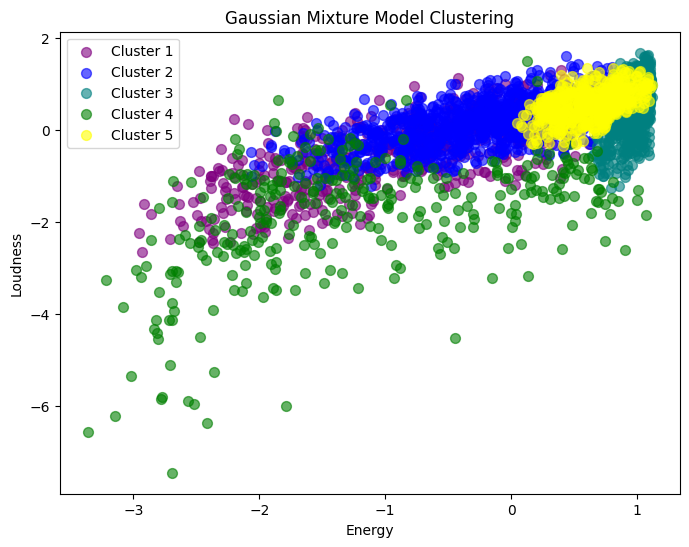

In [ ]:
colours = ['purple', 'blue', 'teal', 'green', 'yellow']
prediction = GMM.predict(standardized_X)
plt.figure(figsize=(8, 6))

for i in range(5):
  cluster_data = standardized_X[prediction == i]
  plt.scatter(cluster_data[:, 1], cluster_data[:, 2], c=colours[i], label=f'Cluster {i+1}', s = 50, alpha= 0.6)

plt.xlabel('Energy')
plt.ylabel('Loudness')
plt.title('Gaussian Mixture Model Clustering')
plt.legend()
plt.show()

# d)

In [ ]:
song_name = 'Detonation'
artist = 'Trivium'
selected_song_idx = df[(df['name'] == song_name) & (df['artist'] == artist)].index

if selected_song_idx.empty:
  print("Song '{}' by '{}' is not found in dataset".format(song_name, artist))
  selected_song_idx = df.index[0]
else:
  selected_song_idx = selected_song_idx[0]

prob_cluster = e_step(standardized_X, GMM.w, GMM.mus, GMM.sigmas)
predicted_cluster = GMM.predict(standardized_X)
cluster = np.argmax(prob_cluster[selected_song_idx])
pos_prob = prob_cluster[selected_song_idx, cluster]

print("\n Selected Song:", df.loc[selected_song_idx, 'name'], 'by', df.loc[selected_song_idx, 'artist'])
print('Assigned Cluster:', cluster + 1, 'with Posterior Probability:', pos_prob)

df['posterior_probability'] = prob_cluster[:, cluster]
same_cluster_songs = df[predicted_cluster == cluster].copy()

playlist = same_cluster_songs.sort_values(by='posterior_probability', ascending=False).head(20)
print("\nSong Radio Playlist (20 songs):")
print(playlist[['name', 'artist', 'posterior_probability']])


 Selected Song: Detonation by Trivium
Assigned Cluster: 5 with Posterior Probability: 0.6038250772925556

Song Radio Playlist (20 songs):
                              name             artist  posterior_probability
292              My Life for Yours  Killswitch Engage               0.960422
1232                     The Cross  Within Temptation               0.955692
473                    Reclamation        Lamb of God               0.952612
1607            Still Of The Night         Whitesnake               0.949740
1681                   Hells Bells              AC/DC               0.949149
1001               Forgotten Faces  Avenged Sevenfold               0.948252
1464                      Sunshine          Aerosmith               0.947153
182               I Die In Degrees   All That Remains               0.946102
1138             This Side Of Fate       Alter Bridge               0.940126
1194    In the Middle of the Night  Within Temptation               0.939232
1201          